In [1]:
from pandas_datareader.data import DataReader
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
tickers = pd.read_csv('data/Holdings.csv')['Ticker'].tolist()
stocks_df = pd.read_csv('data/pricing.csv').set_index('Date')
daily_returns = pd.read_csv('data/daily_return.csv').set_index('Date')

KeyboardInterrupt: 

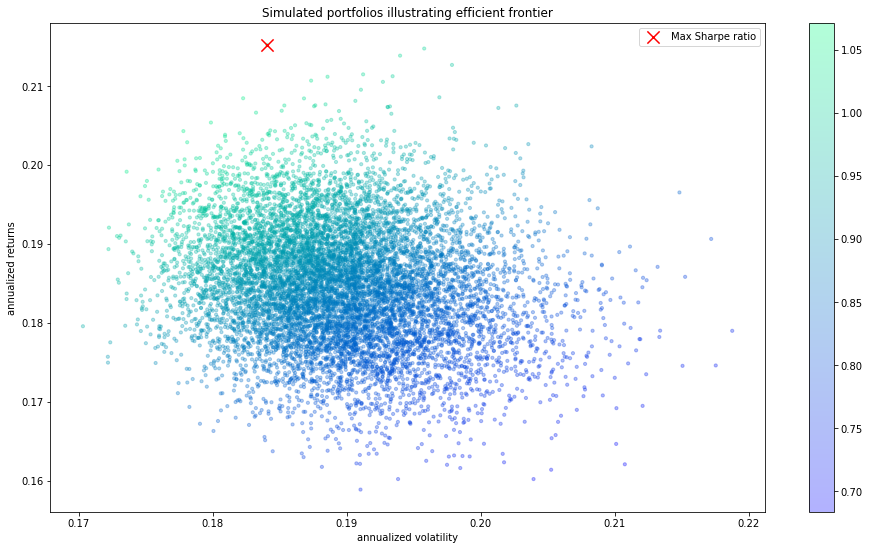

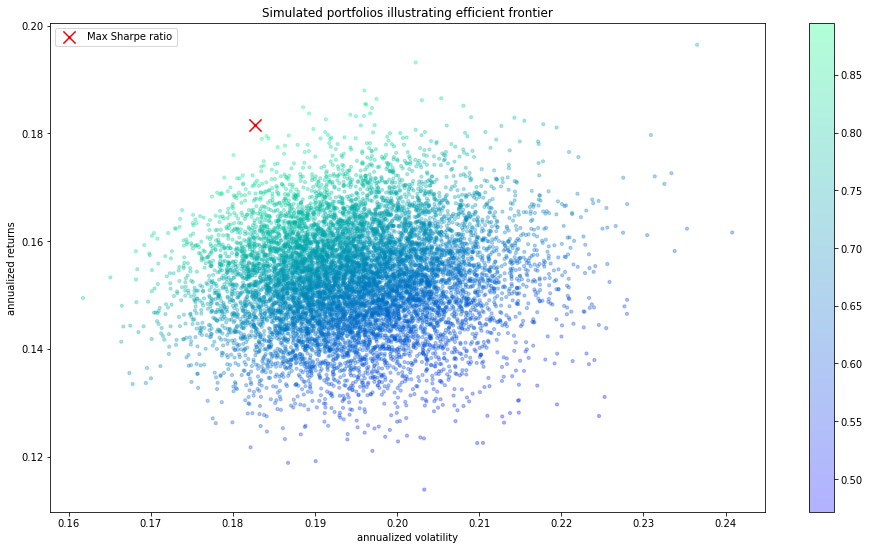

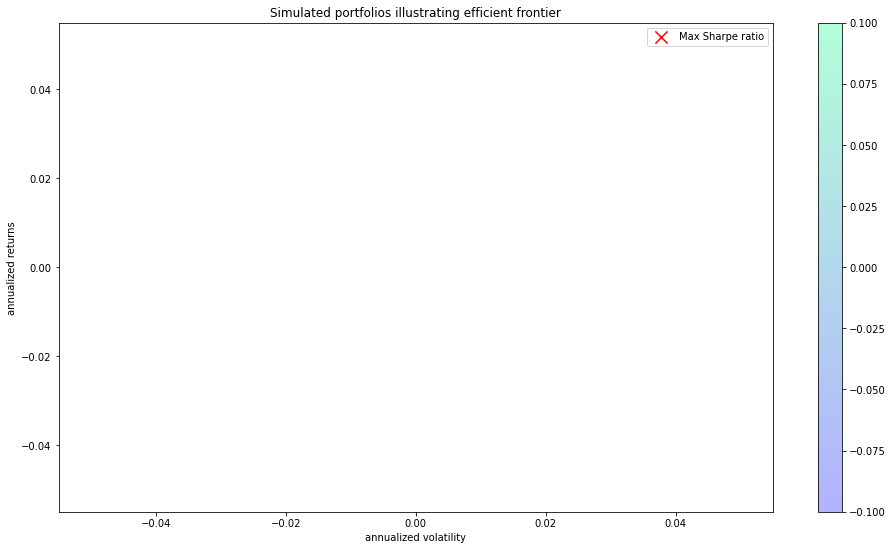

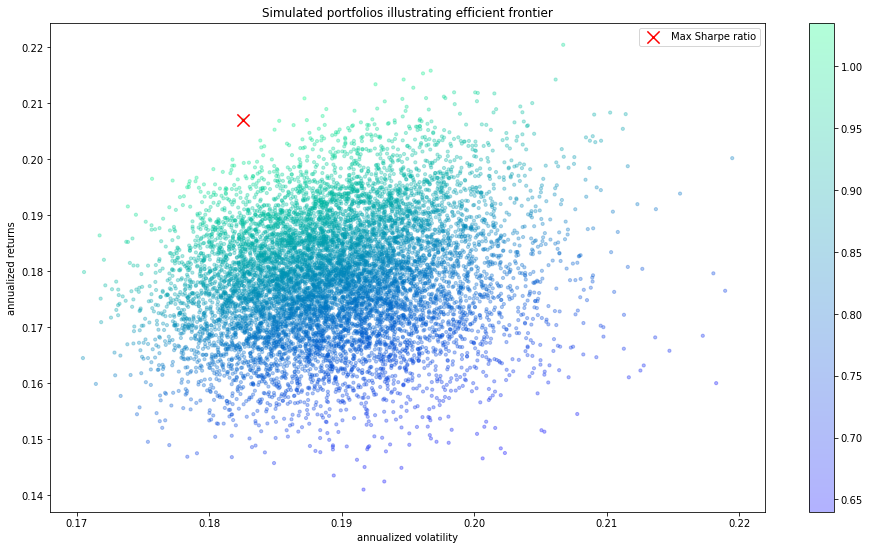

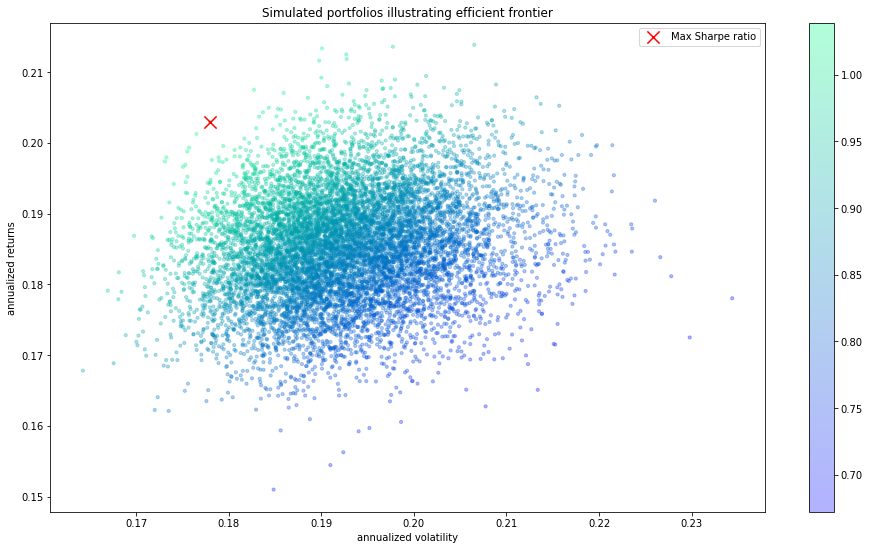

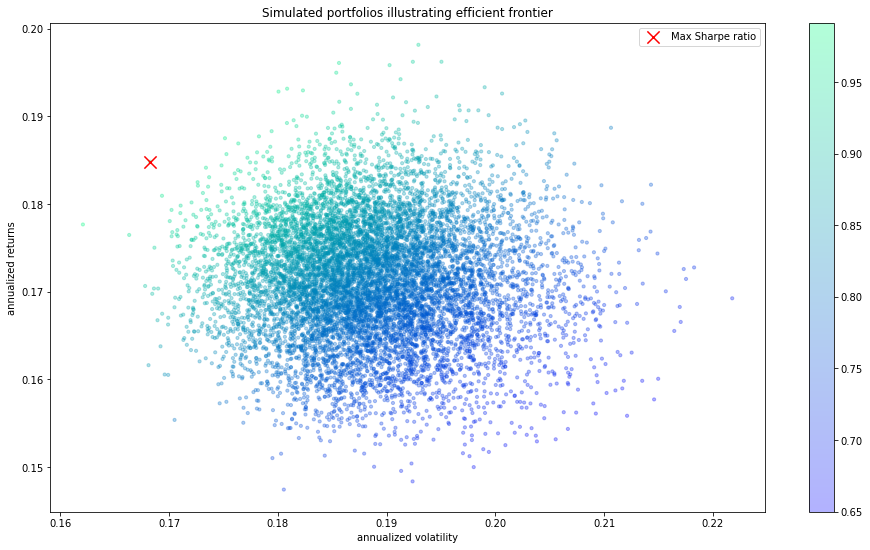

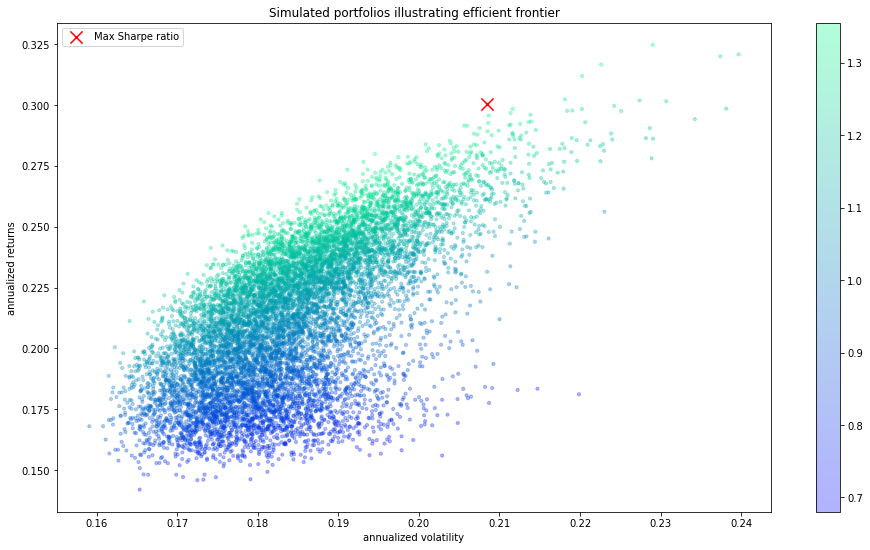

In [97]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) *252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 equities
        weights = np.random.random(15)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

def display_simulated_portfolios(number, mean_returns, cov_matrix, num_portfolios, risk_free_rate):

    # pull results, weights from random portfolios
    results, weights = generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=portfolio, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    # max_sharpe_allocation = max_sharpe_allocation.T
    
    # Visual display of the results on console
    # print("Portfolio number" + str(number))
    # print("--Returns, volatility--\n")
    # print("Annualized Return:", round(returns_portfolio,2))
    # print("Annualized Volatility:", round(stdev_portfolio,2))
    
    # print("\n")
    # print("--Allocation at max Sharpe ratio--\n")
    # print(max_sharpe_allocation)
    
    # Create plot of sharpe ratio
    plt.figure(figsize=(16, 9))
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)

    # Save portfolio allocation and figure to /data/generatedportfolios
    max_sharpe_allocation.to_csv('data/generatedportfolios/portfolioweights.csv', mode='a', header=False)
    plt.savefig('data/generatedportfolios/figures/'+str(number)+'.png')

    # Save returns and volatility to dataframe
    d = {'Portfolio': number, 'Annualized Return': returns_portfolio, 'Annualized Volatility': stdev_portfolio}
    df = pd.DataFrame(data=d,index=[0])
    df.to_csv('data/generatedportfolios/portfolioresults.csv', mode='a', header=False)

num_portfolios = 10000
risk_free_rate = 0.018

number = 0

df = pd.DataFrame(columns=['Portfolio','Annualized Return', 'Annualized Volatility'])
portfolios = pd.read_csv('data/portfolios.csv')

for row in portfolios.index:
    # Load each portfolio
    portfolio = np.array(portfolios.iloc[row])
    portfolio = portfolio[1:]

    returns = daily_returns[portfolio]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    display_simulated_portfolios(number, mean_returns, cov_matrix, num_portfolios, risk_free_rate)

    number = number + 1